In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##1. Imports and Functions

In [ ]:
"""
ABIDE Dataset - Logistic Regression Analysis Suite
Refactored for efficiency and modularity
"""

# ============================================================================
# IMPORTS
# ============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
import os
import random

from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             precision_score, recall_score, confusion_matrix,
                             roc_curve, auc, precision_recall_curve,
                             average_precision_score)

warnings.filterwarnings('ignore')

# ============================================================================
# GLOBAL SETUP
# ============================================================================
SEED = 42

def set_seeds(seed=42):
    """Set all random seeds for reproducibility"""
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seeds(SEED)

# ============================================================================
# DATA LOADING AND PREPROCESSING
# ============================================================================
def load_and_preprocess_data(filepath):
    """Load ABIDE dataset and perform initial preprocessing"""
    df = pd.read_csv(filepath)

    # Label Encoding (2 -> 0 for Control, 1 -> 1 for ASD)
    if 2 in df["DX_GROUP"].values:
        df["DX_GROUP"] = df["DX_GROUP"].replace({2: 0, 1: 1})

    X = df.drop(["SUB_ID", "DX_GROUP"], axis=1, errors='ignore').values
    y = df["DX_GROUP"].values
    feature_names = df.drop(["SUB_ID", "DX_GROUP"], axis=1).columns

    return X, y, feature_names

# ============================================================================
# VISUALIZATION FUNCTIONS
# ============================================================================
def plot_performance_metrics(y_test, y_pred_test, y_prob_test, title_prefix="Model"):
    """Create 3-panel visualization: ROC, PR Curve, and Confusion Matrix"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    plt.suptitle(f"{title_prefix} Performance (Hold-out Test Set)",
                 fontsize=16, fontweight='bold', y=1.02)

    # 1. ROC CURVE
    fpr, tpr, _ = roc_curve(y_test, y_prob_test)
    roc_auc_val = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc_val:.3f}')
    axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0].set_title('ROC Curve')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].legend(loc="lower right")
    axes[0].grid(alpha=0.3)

    # 2. PRECISION-RECALL CURVE
    precision, recall, _ = precision_recall_curve(y_test, y_prob_test)
    avg_precision = average_precision_score(y_test, y_prob_test)
    axes[1].plot(recall, precision, color='green', lw=2, label=f'AP = {avg_precision:.3f}')
    axes[1].set_title('Precision-Recall Curve')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].legend(loc="lower left")
    axes[1].grid(alpha=0.3)

    # 3. CONFUSION MATRIX
    cm = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[2], cbar=False,
                xticklabels=['Control', 'ASD'], yticklabels=['Control', 'ASD'],
                annot_kws={"size": 14})
    axes[2].set_title('Confusion Matrix')
    axes[2].set_ylabel('True Label')
    axes[2].set_xlabel('Predicted Label')

    plt.tight_layout()
    plt.show()

def plot_shap_analysis(model, X_train, X_test, feature_names, title="SHAP Feature Importance"):
    """Generate SHAP summary plot"""
    print(f"\nGenerating {title}...")
    X_bg = shap.sample(X_train, 100)
    explainer = shap.LinearExplainer(model, X_bg)
    shap_values = explainer.shap_values(X_test[:100])

    plt.figure()
    shap.summary_plot(shap_values, X_test[:100], feature_names=feature_names, show=False)
    plt.title(title)
    plt.show()

# ============================================================================
# CROSS-VALIDATION FUNCTION
# ============================================================================
def run_cross_validation(X_data, y_data, model_pipeline_func, k_folds, name):
    """
    Generic cross-validation runner

    Parameters:
    -----------
    X_data : array
        Feature matrix
    y_data : array
        Target labels
    model_pipeline_func : callable
        Function that takes (X_train, y_train, X_val) and returns (model, X_val_transformed)
    k_folds : int
        Number of CV folds
    name : str
        Name for reporting
    """
    cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=SEED)
    metrics = {'acc': [], 'prec': [], 'f1': [], 'auc': []}

    for train_idx, val_idx in cv.split(X_data, y_data):
        X_tr, X_val = X_data[train_idx], X_data[val_idx]
        y_tr, y_val = y_data[train_idx], y_data[val_idx]

        model, X_val_transformed = model_pipeline_func(X_tr, y_tr, X_val)

        y_pred = model.predict(X_val_transformed)
        y_prob = model.predict_proba(X_val_transformed)[:, 1]

        metrics['acc'].append(accuracy_score(y_val, y_pred))
        metrics['prec'].append(precision_score(y_val, y_pred, zero_division=0))
        metrics['f1'].append(f1_score(y_val, y_pred, zero_division=0))
        metrics['auc'].append(roc_auc_score(y_val, y_prob))

    print(f"\n====== {name} Results ======")
    print(f"Mean Accuracy:  {np.mean(metrics['acc']):.4f} ± {np.std(metrics['acc']):.4f}")
    print(f"Mean Precision: {np.mean(metrics['prec']):.4f} ± {np.std(metrics['prec']):.4f}")
    print(f"Mean F1 Score:  {np.mean(metrics['f1']):.4f} ± {np.std(metrics['f1']):.4f}")
    print(f"Mean AUC:       {np.mean(metrics['auc']):.4f} ± {np.std(metrics['auc']):.4f}")

def evaluate_test_set(model, X_test, y_test):
    """Evaluate model on test set and return metrics"""
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'auc': roc_auc_score(y_test, y_prob)
    }

    return y_pred, y_prob, metrics

def print_test_results(metrics, title="FINAL TEST RESULTS"):
    """Print test set metrics"""
    print(f"\n====== {title} (30% Hold-out) ======")
    print(f"Test Accuracy:  {metrics['accuracy']:.4f}")
    print(f"Test Precision: {metrics['precision']:.4f}")
    print(f"Test F1 Score:  {metrics['f1']:.4f}")
    print(f"Test AUC:       {metrics['auc']:.4f}")

# ============================================================================
# MAIN EXECUTION
# ============================================================================
print("="*60)
print("LOADING ABIDE DATASET")
print("="*60)

# Load data
filepath = "/content/drive/MyDrive/ABIDE/ABIDE_CC200_FINAL_NO_NAN.csv"
X, y, feature_names = load_and_preprocess_data(filepath)

# Train-test split
X_dev, X_test, y_dev, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=SEED
)

print(f"\nDevelopment Set (for CV): {X_dev.shape[0]} samples")
print(f"Hold-out Test Set:        {X_test.shape[0]} samples")
print(f"Total Features:           {X_dev.shape[1]}")

LOADING ABIDE DATASET

Development Set (for CV): 594 samples
Hold-out Test Set:        255 samples
Total Features:           19900


##2. Raw Logistic Regression


BLOCK 1: LOGISTIC REGRESSION (LASSO/L1)

====== Raw LR 5-Fold Cross-Validation Results ======
Mean Accuracy:  0.6297 ± 0.0445
Mean Precision: 0.5972 ± 0.0462
Mean F1 Score:  0.6016 ± 0.0540
Mean AUC:       0.6647 ± 0.0406

====== Raw LR 10-Fold Cross-Validation Results ======
Mean Accuracy:  0.6231 ± 0.0687
Mean Precision: 0.5875 ± 0.0750
Mean F1 Score:  0.5903 ± 0.0920
Mean AUC:       0.6692 ± 0.0777

====== Logistic Regression FINAL TEST RESULTS (30% Hold-out) ======
Test Accuracy:  0.6039
Test Precision: 0.5714
Test F1 Score:  0.5590
Test AUC:       0.6967


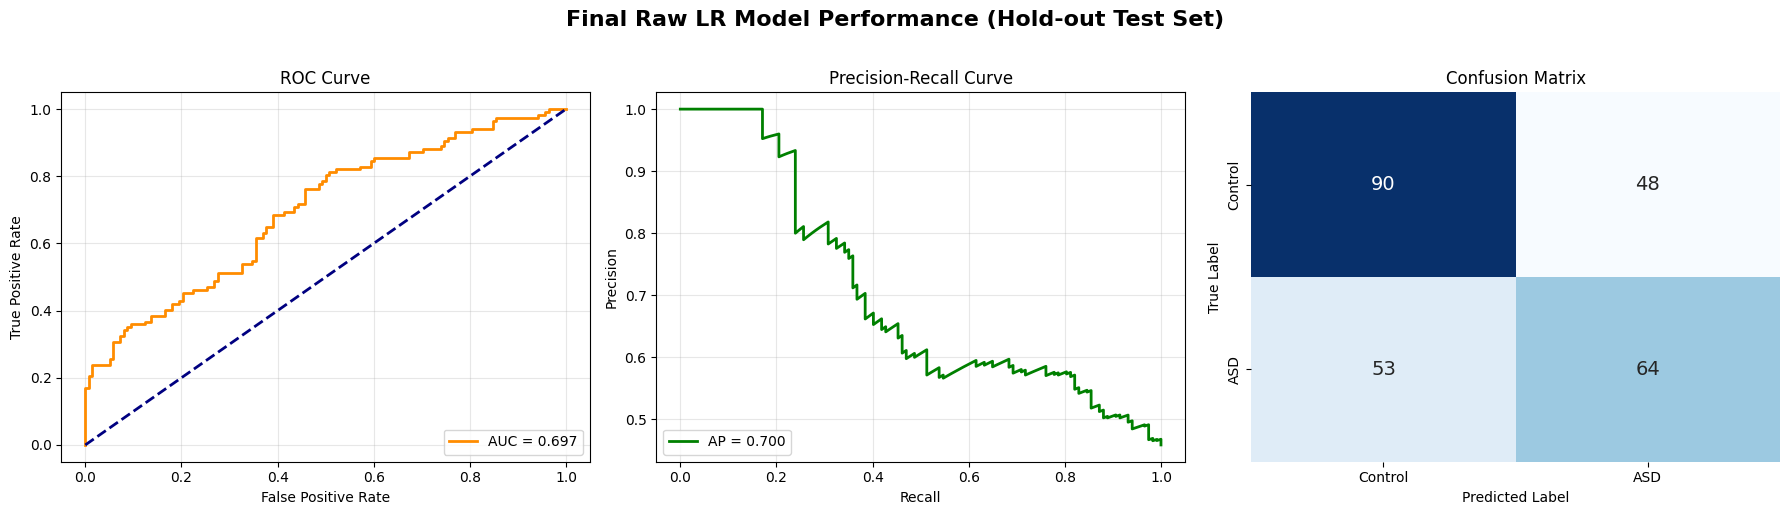


Generating SHAP Feature Importance (Top Features)...


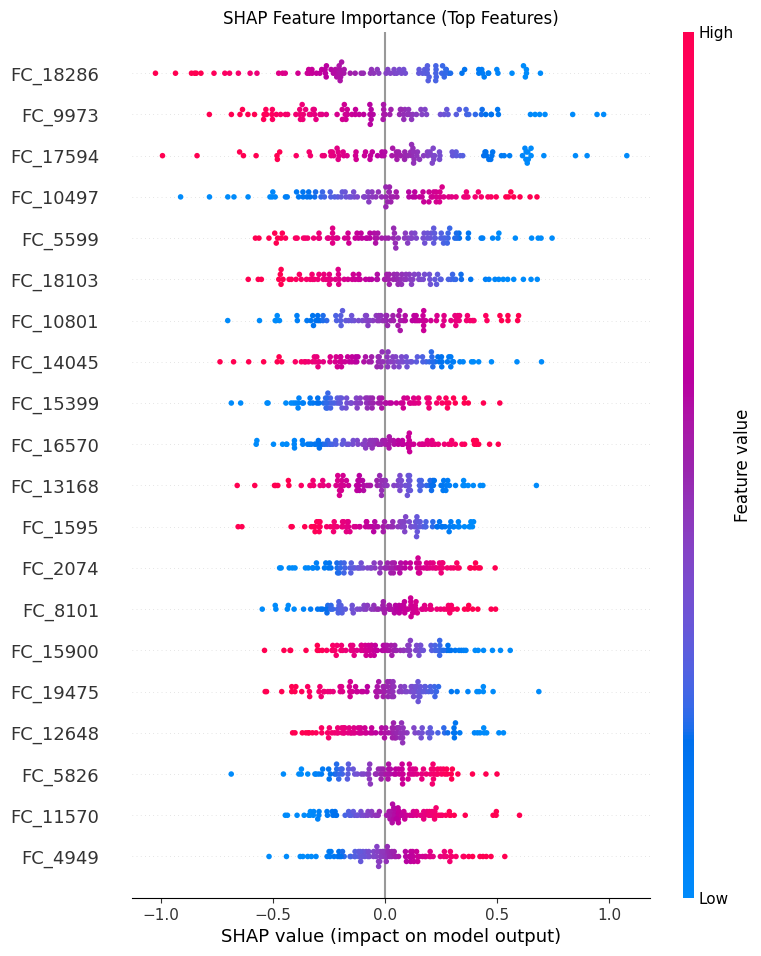

In [ ]:
# ============================================================================
# BLOCK 1: RAW LOGISTIC REGRESSION (L1/LASSO)
# ============================================================================
print("\n" + "="*60)
print("BLOCK 1: LOGISTIC REGRESSION (LASSO/L1)")
print("="*60)

# Pipeline function for raw LR
def raw_lr_pipeline(X_train, y_train, X_val):
    """Scale + Train L1 Logistic Regression"""
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s = scaler.transform(X_val)

    model = LogisticRegression(penalty='l1', C=1.0, solver='liblinear',
                               max_iter=1000, random_state=SEED)
    model.fit(X_train_s, y_train)

    return model, X_val_s

# Cross-validation
run_cross_validation(X_dev, y_dev, raw_lr_pipeline, k_folds=5,
                     name="Raw LR 5-Fold Cross-Validation")
run_cross_validation(X_dev, y_dev, raw_lr_pipeline, k_folds=10,
                     name="Raw LR 10-Fold Cross-Validation")

# Final model training
scaler_final = StandardScaler()
X_dev_s = scaler_final.fit_transform(X_dev)
X_test_s = scaler_final.transform(X_test)

model_final = LogisticRegression(penalty='l1', C=1.0, solver='liblinear',
                                  max_iter=1000, random_state=SEED)
model_final.fit(X_dev_s, y_dev)

# Evaluation
y_pred_test, y_prob_test, metrics = evaluate_test_set(model_final, X_test_s, y_test)
print_test_results(metrics, "Logistic Regression FINAL TEST RESULTS")

# Visualization
plot_performance_metrics(y_test, y_pred_test, y_prob_test, "Final Raw LR Model")

# SHAP Analysis
plot_shap_analysis(model_final, X_dev_s, X_test_s, feature_names,
                   "SHAP Feature Importance (Top Features)")

##3. LR + PCA


BLOCK 2: LOGISTIC REGRESSION + PCA

====== PCA + LR 5-Fold Cross-Validation Results ======
Avg Components Used: 401
Mean Accuracy:  0.6498 ± 0.0178
Mean Precision: 0.6343 ± 0.0215
Mean F1 Score:  0.5989 ± 0.0425
Mean AUC:       0.7149 ± 0.0216

====== PCA + LR 10-Fold Cross-Validation Results ======
Avg Components Used: 448
Mean Accuracy:  0.6601 ± 0.0624
Mean Precision: 0.6454 ± 0.0786
Mean F1 Score:  0.6178 ± 0.0732
Mean AUC:       0.7204 ± 0.0723

Final PCA retained 495 components (95% Variance).

====== PCA + LR FINAL TEST RESULTS (30% Hold-out) ======
Test Accuracy:  0.6706
Test Precision: 0.6634
Test F1 Score:  0.6147
Test AUC:       0.7172


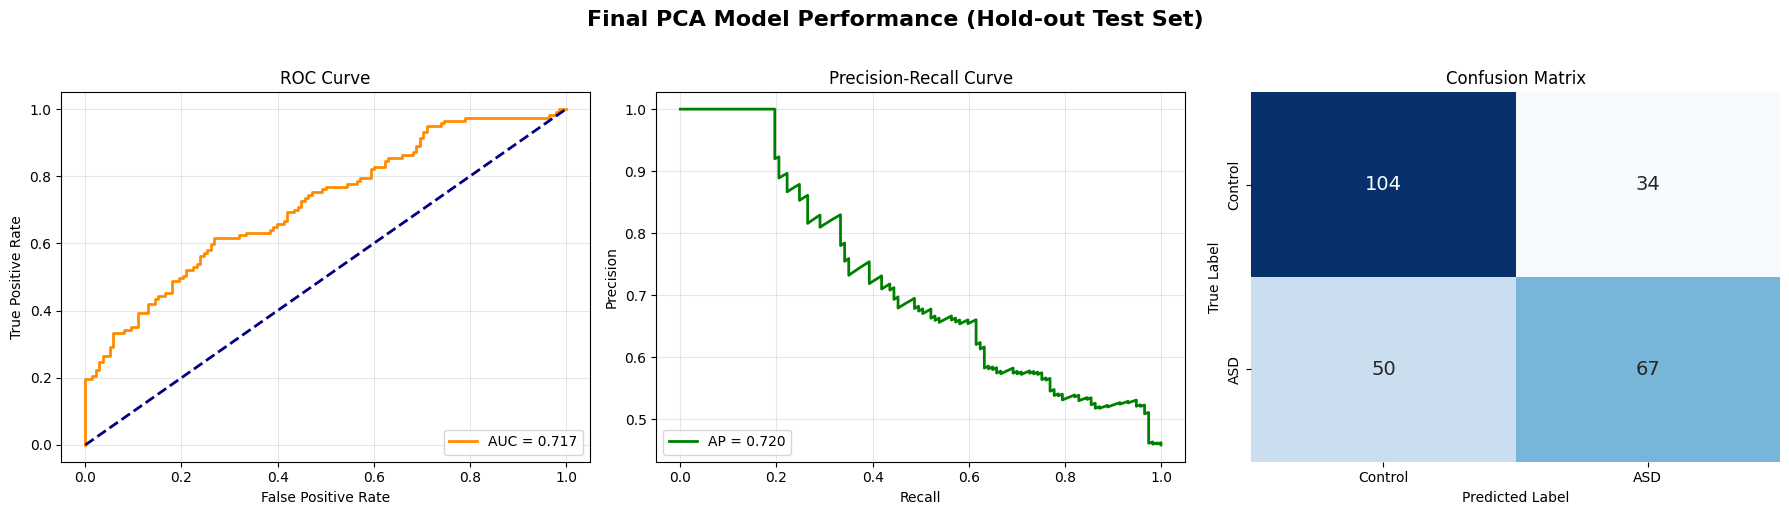


Generating SHAP Feature Importance (Principal Components)...


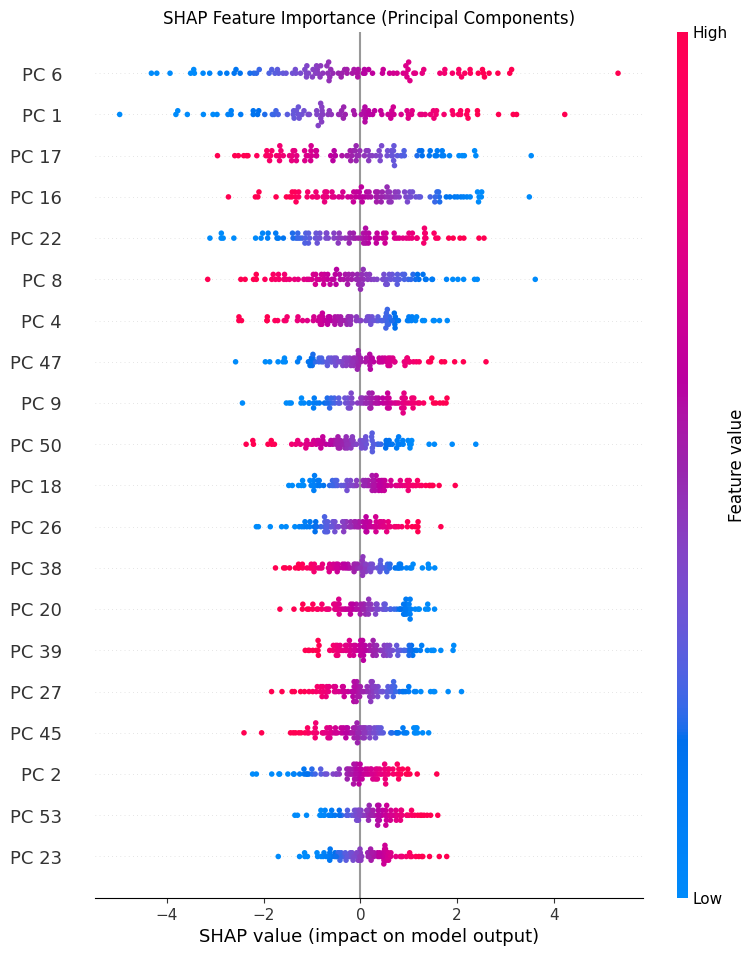


DECODING PC_6: Which brain regions make up this component?
Top 20 Brain Connections contributing to PC_6:

Rank  Weight     Feature Name
------------------------------------------------------------
1     0.0266     FC_8033
2     0.0250     FC_16303
3     0.0244     FC_13692
4     -0.0239     FC_6123
5     -0.0237     FC_11817
6     0.0234     FC_9803
7     0.0232     FC_6050
8     0.0231     FC_10877
9     0.0228     FC_13715
10    0.0227     FC_6258
11    0.0227     FC_13572
12    0.0225     FC_12911
13    -0.0224     FC_4372
14    0.0224     FC_4388
15    0.0221     FC_16268
16    -0.0220     FC_17895
17    0.0219     FC_4430
18    0.0217     FC_8082
19    -0.0217     FC_10994
20    -0.0216     FC_6242


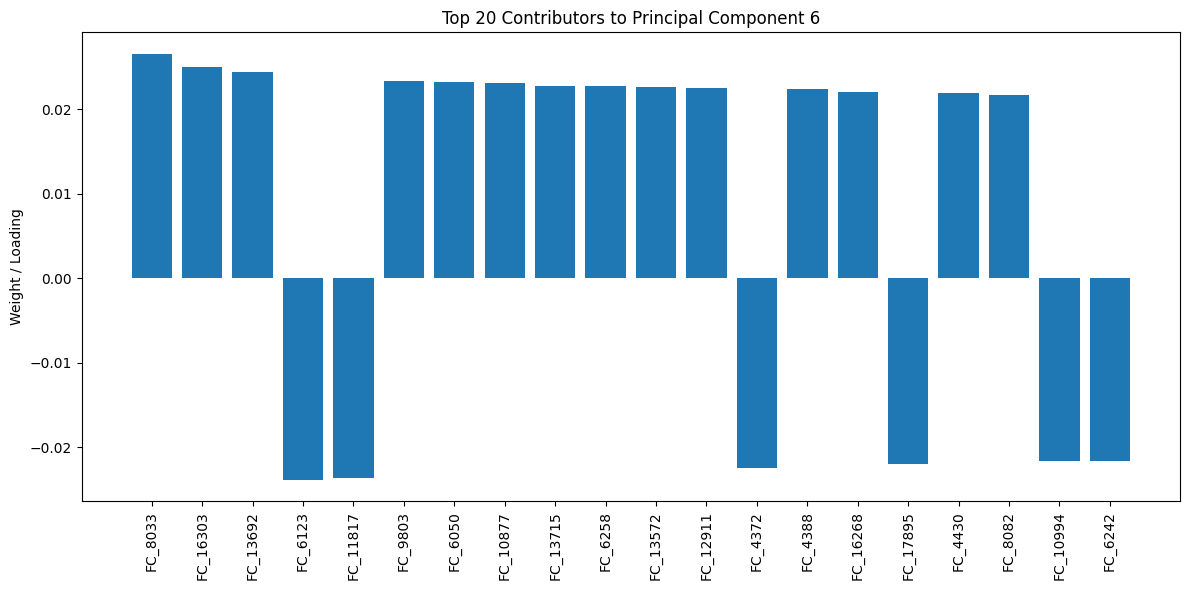

In [ ]:
# ============================================================================
# BLOCK 2: LOGISTIC REGRESSION + PCA
# ============================================================================
print("\n" + "="*60)
print("BLOCK 2: LOGISTIC REGRESSION + PCA")
print("="*60)

# Pipeline function for PCA + LR
def pca_lr_pipeline(X_train, y_train, X_val):
    """Scale + PCA + Train LR"""
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s = scaler.transform(X_val)

    pca = PCA(n_components=0.95, random_state=SEED)
    X_train_pca = pca.fit_transform(X_train_s)
    X_val_pca = pca.transform(X_val_s)

    model = LogisticRegression(max_iter=1000, random_state=SEED)
    model.fit(X_train_pca, y_train)

    return model, X_val_pca

# Enhanced CV function for PCA (to track components)
def run_pca_cv(X_data, y_data, k_folds, name):
    cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=SEED)
    metrics = {'acc': [], 'prec': [], 'f1': [], 'auc': [], 'n_components': []}

    for train_idx, val_idx in cv.split(X_data, y_data):
        X_tr, X_val = X_data[train_idx], X_data[val_idx]
        y_tr, y_val = y_data[train_idx], y_data[val_idx]

        scaler = StandardScaler()
        X_tr_s = scaler.fit_transform(X_tr)
        X_val_s = scaler.transform(X_val)

        pca = PCA(n_components=0.95, random_state=SEED)
        X_tr_pca = pca.fit_transform(X_tr_s)
        X_val_pca = pca.transform(X_val_s)

        metrics['n_components'].append(pca.n_components_)

        model = LogisticRegression(max_iter=1000, random_state=SEED)
        model.fit(X_tr_pca, y_tr)

        y_pred = model.predict(X_val_pca)
        y_prob = model.predict_proba(X_val_pca)[:, 1]

        metrics['acc'].append(accuracy_score(y_val, y_pred))
        metrics['prec'].append(precision_score(y_val, y_pred, zero_division=0))
        metrics['f1'].append(f1_score(y_val, y_pred, zero_division=0))
        metrics['auc'].append(roc_auc_score(y_val, y_prob))

    print(f"\n====== PCA + LR {name} Results ======")
    print(f"Avg Components Used: {int(np.mean(metrics['n_components']))}")
    print(f"Mean Accuracy:  {np.mean(metrics['acc']):.4f} ± {np.std(metrics['acc']):.4f}")
    print(f"Mean Precision: {np.mean(metrics['prec']):.4f} ± {np.std(metrics['prec']):.4f}")
    print(f"Mean F1 Score:  {np.mean(metrics['f1']):.4f} ± {np.std(metrics['f1']):.4f}")
    print(f"Mean AUC:       {np.mean(metrics['auc']):.4f} ± {np.std(metrics['auc']):.4f}")

# Cross-validation
run_pca_cv(X_dev, y_dev, k_folds=5, name="5-Fold Cross-Validation")
run_pca_cv(X_dev, y_dev, k_folds=10, name="10-Fold Cross-Validation")

# Final model training
scaler_final = StandardScaler()
X_dev_s = scaler_final.fit_transform(X_dev)
X_test_s = scaler_final.transform(X_test)

pca_final = PCA(n_components=0.95, random_state=SEED)
X_dev_pca = pca_final.fit_transform(X_dev_s)
X_test_pca = pca_final.transform(X_test_s)

print(f"\nFinal PCA retained {pca_final.n_components_} components (95% Variance).")

model_final = LogisticRegression(max_iter=1000, random_state=SEED)
model_final.fit(X_dev_pca, y_dev)

# Evaluation
y_pred_test, y_prob_test, metrics = evaluate_test_set(model_final, X_test_pca, y_test)
print_test_results(metrics, "PCA + LR FINAL TEST RESULTS")

# Visualization
plot_performance_metrics(y_test, y_pred_test, y_prob_test, "Final PCA Model")

# SHAP Analysis
pc_feature_names = [f"PC {i+1}" for i in range(X_test_pca.shape[1])]
plot_shap_analysis(model_final, X_dev_pca, X_test_pca, pc_feature_names,
                   "SHAP Feature Importance (Principal Components)")

# ============================================================================
# BONUS: DECODE PC_6 (Optional - run if you want to see top contributors)
# ============================================================================
print("\n" + "="*60)
print("DECODING PC_6: Which brain regions make up this component?")
print("="*60)

pc6_weights = pca_final.components_[5]
sorted_indices = np.argsort(np.abs(pc6_weights))[::-1]

print("Top 20 Brain Connections contributing to PC_6:\n")
print(f"{'Rank':<5} {'Weight':<10} {'Feature Name'}")
print("-" * 60)

for i in range(20):
    idx = sorted_indices[i]
    weight = pc6_weights[idx]
    feat_name = feature_names[idx]
    print(f"{i+1:<5} {weight:.4f}     {feat_name}")

# Visualize weights
plt.figure(figsize=(12, 6))
plt.bar(range(20), pc6_weights[sorted_indices[:20]], align='center')
plt.xticks(range(20), feature_names[sorted_indices[:20]], rotation=90)
plt.ylabel('Weight / Loading')
plt.title('Top 20 Contributors to Principal Component 6')
plt.tight_layout()
plt.show()

## 4. LR + SelectKBest


BLOCK 3: HYPERPARAMETER TUNING - FINDING THE BEST 'K'

Starting Grid Search...
K-Features      Mean AUC       
------------------------------
100             0.6691
500             0.6765
1000            0.6859
2000            0.7063
3000            0.7045
5000            0.7151


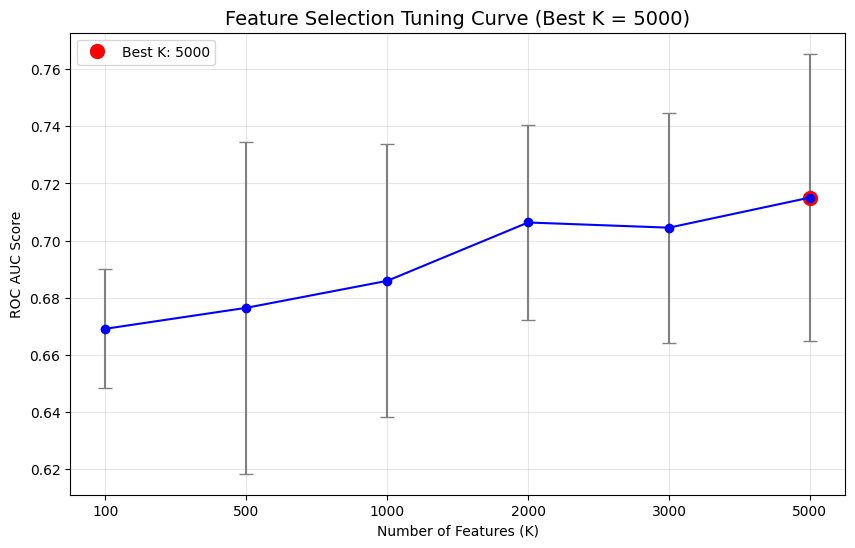

WINNER: The optimal number of features is 5000 (AUC: 0.7151)

Using K = 5000 for SelectKBest analysis...


In [ ]:
# ============================================================================
# BLOCK 3: HYPERPARAMETER TUNING - FINDING BEST K FOR SELECTKBEST
# ============================================================================
print("\n" + "="*60)
print("BLOCK 3: HYPERPARAMETER TUNING - FINDING THE BEST 'K'")
print("="*60)

# K values to test
k_options = [100, 500, 1000, 2000, 3000, 5000]
k_options = [k for k in k_options if k == 'all' or k <= X_dev.shape[1]]

results = {'k': [], 'mean_auc': [], 'std_auc': []}

print("\nStarting Grid Search...")
print(f"{'K-Features':<15} {'Mean AUC':<15}")
print("-" * 30)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for k in k_options:
    fold_aucs = []

    for train_idx, val_idx in cv.split(X_dev, y_dev):
        X_tr, X_val = X_dev[train_idx], X_dev[val_idx]
        y_tr, y_val = y_dev[train_idx], y_dev[val_idx]

        # Scale
        scaler = StandardScaler()
        X_tr_s = scaler.fit_transform(X_tr)
        X_val_s = scaler.transform(X_val)

        # Select Features
        selector = SelectKBest(f_classif, k=k)
        X_tr_k = selector.fit_transform(X_tr_s, y_tr)
        X_val_k = selector.transform(X_val_s)

        # Train Model
        model = LogisticRegression(max_iter=1000, random_state=SEED)
        model.fit(X_tr_k, y_tr)

        # Score
        y_prob = model.predict_proba(X_val_k)[:, 1]
        fold_aucs.append(roc_auc_score(y_val, y_prob))

    mean_score = np.mean(fold_aucs)
    std_score = np.std(fold_aucs)

    results['k'].append(str(k))
    results['mean_auc'].append(mean_score)
    results['std_auc'].append(std_score)

    print(f"{str(k):<15} {mean_score:.4f}")

# Visualize tuning curve
best_idx = np.argmax(results['mean_auc'])
best_k = results['k'][best_idx]
best_score = results['mean_auc'][best_idx]

plt.figure(figsize=(10, 6))
plt.errorbar(results['k'], results['mean_auc'], yerr=results['std_auc'],
             fmt='o-', color='b', ecolor='gray', capsize=5)
plt.plot(best_idx, best_score, 'ro', markersize=10, label=f'Best K: {best_k}')

plt.title(f"Feature Selection Tuning Curve (Best K = {best_k})", fontsize=14)
plt.xlabel("Number of Features (K)")
plt.ylabel("ROC AUC Score")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print("="*60)
print(f"WINNER: The optimal number of features is {best_k} (AUC: {best_score:.4f})")
print("="*60)

# Store best K for next block
BEST_K = int(best_k) if best_k != 'all' else X_dev.shape[1]
print(f"\nUsing K = {BEST_K} for SelectKBest analysis...")


BLOCK 4: LOGISTIC REGRESSION + SELECTKBEST (K=5000)

====== SelectKBest(5000) + LR 5-Fold CV Results ======
Mean Accuracy:  0.6482 ± 0.0337
Mean Precision: 0.6195 ± 0.0291
Mean F1 Score:  0.6098 ± 0.0646
Mean AUC:       0.7151 ± 0.0503

====== SelectKBest(5000) + LR 10-Fold CV Results ======
Mean Accuracy:  0.6853 ± 0.0448
Mean Precision: 0.6643 ± 0.0528
Mean F1 Score:  0.6550 ± 0.0496
Mean AUC:       0.7251 ± 0.0742

Final SelectKBest retained top 5000 features.

====== SelectKBest + LR FINAL TEST RESULTS (30% Hold-out) ======
Test Accuracy:  0.6667
Test Precision: 0.6429
Test F1 Score:  0.6288
Test AUC:       0.7137


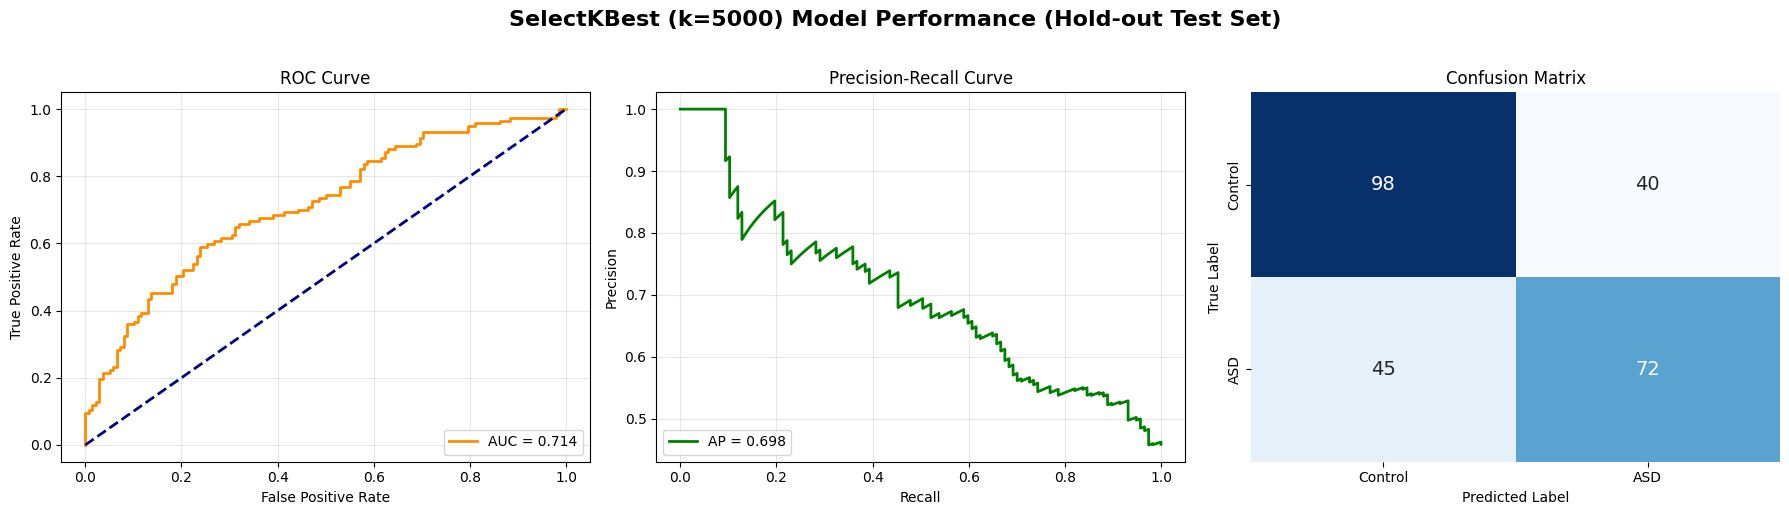


Generating SHAP Feature Importance (Top 5000 Selected Features)...


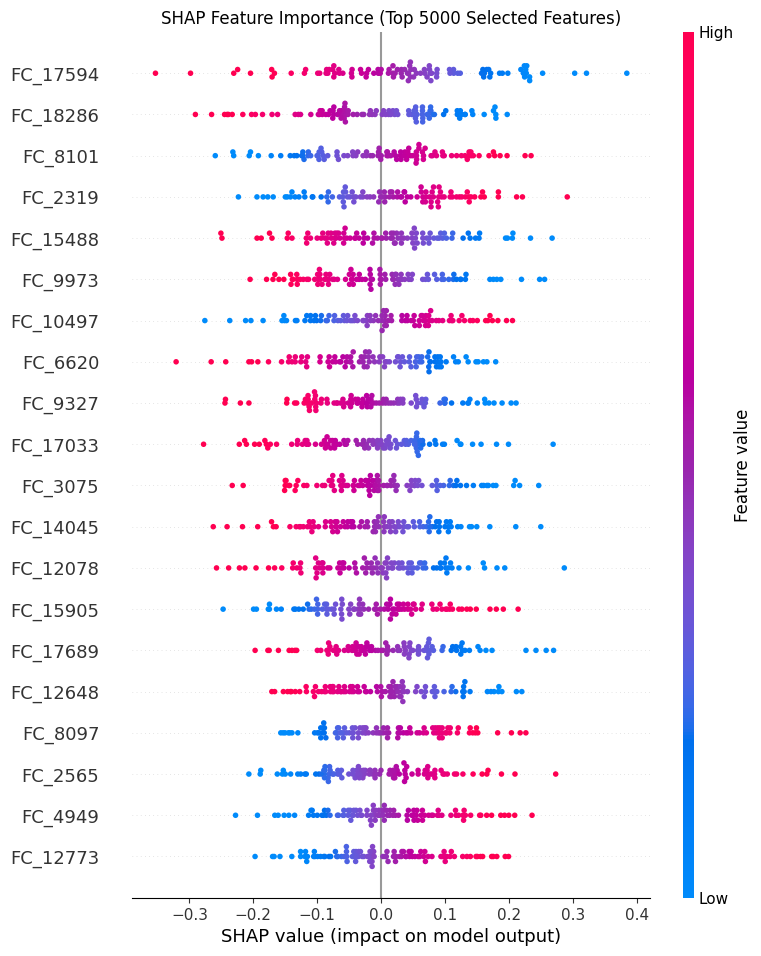

In [ ]:
# ============================================================================
# BLOCK 4: LOGISTIC REGRESSION + SELECTKBEST
# ============================================================================
print("\n" + "="*60)
print(f"BLOCK 4: LOGISTIC REGRESSION + SELECTKBEST (K={BEST_K})")
print("="*60)

# Pipeline function for SelectKBest + LR
def selectkbest_lr_pipeline(X_train, y_train, X_val, k_features=BEST_K):
    """Scale + SelectKBest + Train LR"""
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s = scaler.transform(X_val)

    selector = SelectKBest(f_classif, k=k_features)
    X_train_k = selector.fit_transform(X_train_s, y_train)
    X_val_k = selector.transform(X_val_s)

    model = LogisticRegression(max_iter=1000, random_state=SEED)
    model.fit(X_train_k, y_train)

    return model, X_val_k

# Cross-validation
run_cross_validation(X_dev, y_dev, selectkbest_lr_pipeline, k_folds=5,
                     name=f"SelectKBest({BEST_K}) + LR 5-Fold CV")
run_cross_validation(X_dev, y_dev, selectkbest_lr_pipeline, k_folds=10,
                     name=f"SelectKBest({BEST_K}) + LR 10-Fold CV")

# Final model training
scaler_final = StandardScaler()
X_dev_s = scaler_final.fit_transform(X_dev)
X_test_s = scaler_final.transform(X_test)

selector_final = SelectKBest(f_classif, k=BEST_K)
X_dev_k = selector_final.fit_transform(X_dev_s, y_dev)
X_test_k = selector_final.transform(X_test_s)

print(f"\nFinal SelectKBest retained top {BEST_K} features.")

model_final = LogisticRegression(max_iter=1000, random_state=SEED)
model_final.fit(X_dev_k, y_dev)

# Evaluation
y_pred_test, y_prob_test, metrics = evaluate_test_set(model_final, X_test_k, y_test)
print_test_results(metrics, "SelectKBest + LR FINAL TEST RESULTS")

# Visualization
plot_performance_metrics(y_test, y_pred_test, y_prob_test,
                        f"SelectKBest (k={BEST_K}) Model")

# SHAP Analysis
selected_mask = selector_final.get_support()
selected_feature_names = feature_names[selected_mask]
plot_shap_analysis(model_final, X_dev_k, X_test_k, selected_feature_names,
                   f"SHAP Feature Importance (Top {BEST_K} Selected Features)")

##5. LR + Lasso


BLOCK 5: LOGISTIC REGRESSION + LASSO (L1) OPTIMIZATION
Strategy: Auto-tune 'C' to maximize Accuracy

====== Lasso Auto-Tuned 5-Fold CV Results ======
Avg Best C:        32.030
Avg Features:      1140
Mean Accuracy:     0.6380 ± 0.0397
Mean Precision:    0.6046 ± 0.0387
Mean F1 Score:     0.6102 ± 0.0494
Mean AUC:          0.6848 ± 0.0485

====== Lasso Auto-Tuned 10-Fold CV Results ======
Avg Best C:        45.020
Avg Features:      1370
Mean Accuracy:     0.6329 ± 0.0560
Mean Precision:    0.6030 ± 0.0640
Mean F1 Score:     0.6011 ± 0.0655
Mean AUC:          0.6836 ± 0.0749

TRAINING FINAL MODEL ON FULL DEVELOPMENT SET...
Optimal C selected: 10
Features Retained:  938

====== LASSO FINAL TEST RESULTS (30% Hold-out) ======
Test Accuracy:  0.6471
Test Precision: 0.6311
Test F1 Score:  0.5909
Test AUC:       0.7206


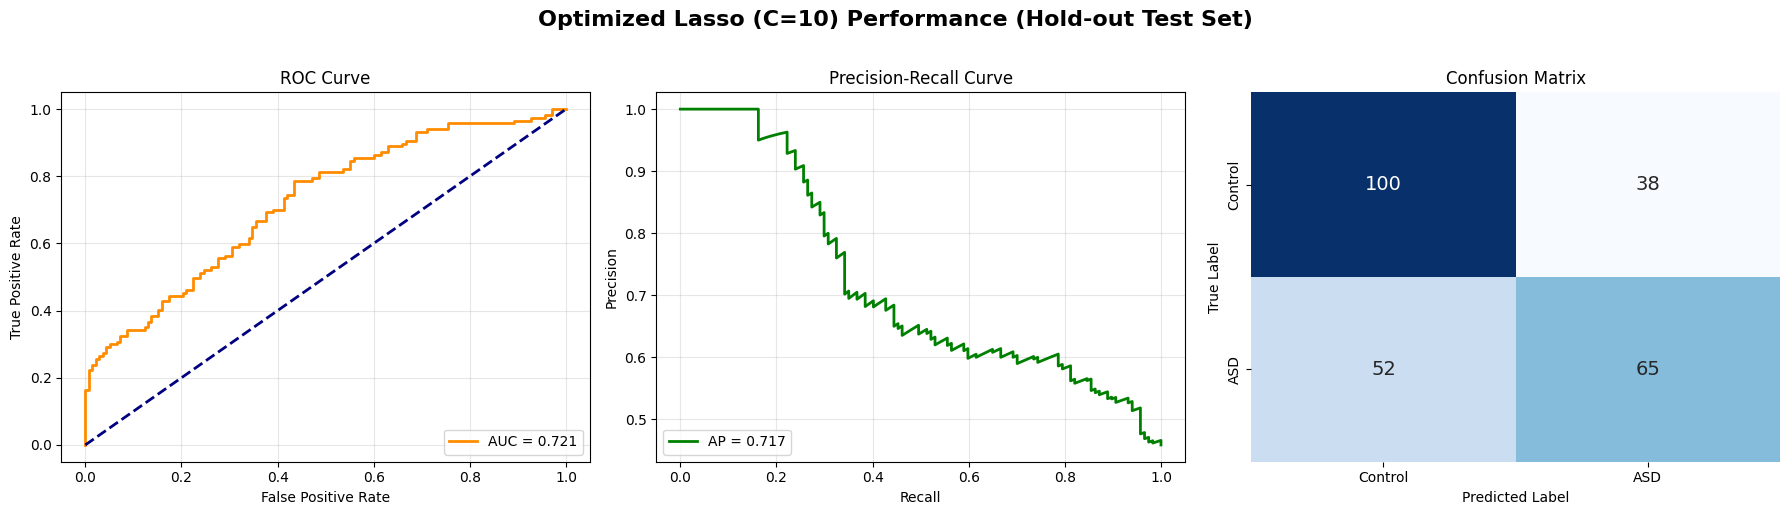


Generating SHAP Feature Importance (Top Features of 938 Selected)...


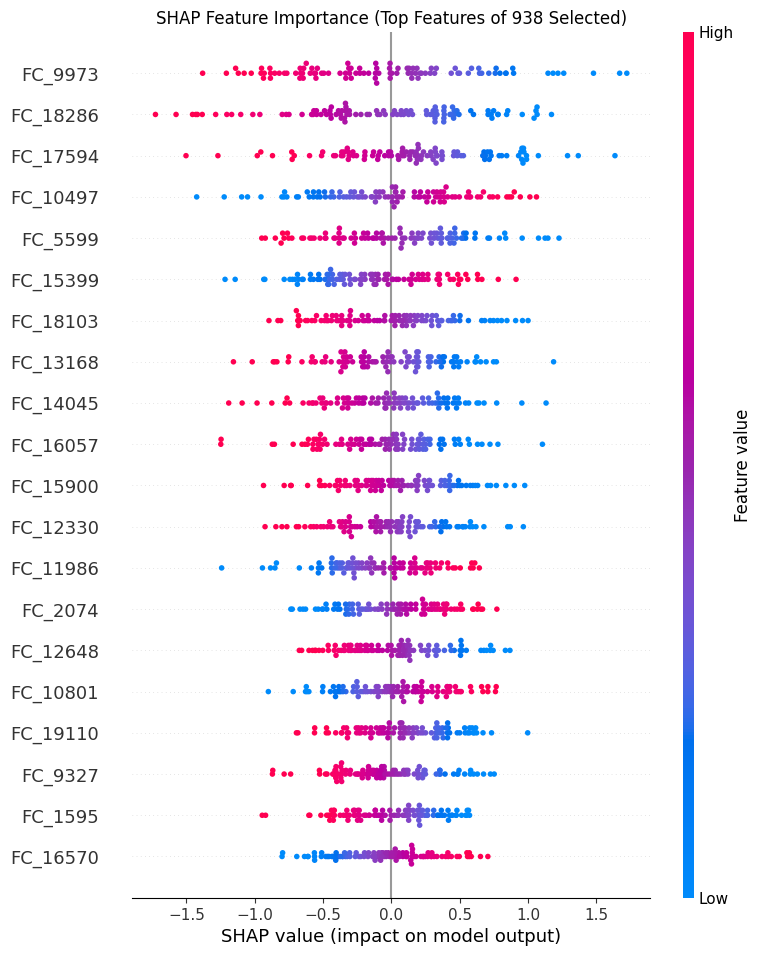

In [ ]:
# ============================================================================
# BLOCK 5: LOGISTIC REGRESSION + LASSO (L1) WITH AUTO-TUNING
# ============================================================================
print("\n" + "="*60)
print("BLOCK 5: LOGISTIC REGRESSION + LASSO (L1) OPTIMIZATION")
print("Strategy: Auto-tune 'C' to maximize Accuracy")
print("="*60)

# Enhanced CV function with GridSearch per fold
def run_lasso_tuned_cv(X_data, y_data, k_folds, name):
    cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=SEED)
    metrics = {'acc': [], 'prec': [], 'f1': [], 'auc': [], 'n_feats': [], 'best_c': []}

    param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 10, 50, 100]}

    for train_idx, val_idx in cv.split(X_data, y_data):
        X_tr, X_val = X_data[train_idx], X_data[val_idx]
        y_tr, y_val = y_data[train_idx], y_data[val_idx]

        # Scale
        scaler = StandardScaler()
        X_tr_s = scaler.fit_transform(X_tr)
        X_val_s = scaler.transform(X_val)

        # Internal tuning with GridSearchCV
        base_model = LogisticRegression(penalty='l1', solver='liblinear',
                                        max_iter=1000, random_state=SEED)
        grid = GridSearchCV(base_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
        grid.fit(X_tr_s, y_tr)

        best_model = grid.best_estimator_
        best_c = grid.best_params_['C']
        metrics['best_c'].append(best_c)

        # Count features
        n_selected = np.sum(best_model.coef_ != 0)
        metrics['n_feats'].append(n_selected)

        # Evaluate
        y_pred = best_model.predict(X_val_s)
        y_prob = best_model.predict_proba(X_val_s)[:, 1]

        metrics['acc'].append(accuracy_score(y_val, y_pred))
        metrics['prec'].append(precision_score(y_val, y_pred, zero_division=0))
        metrics['f1'].append(f1_score(y_val, y_pred, zero_division=0))
        metrics['auc'].append(roc_auc_score(y_val, y_prob))

    print(f"\n====== Lasso Auto-Tuned {name} Results ======")
    print(f"Avg Best C:        {np.mean(metrics['best_c']):.3f}")
    print(f"Avg Features:      {int(np.mean(metrics['n_feats']))}")
    print(f"Mean Accuracy:     {np.mean(metrics['acc']):.4f} ± {np.std(metrics['acc']):.4f}")
    print(f"Mean Precision:    {np.mean(metrics['prec']):.4f} ± {np.std(metrics['prec']):.4f}")
    print(f"Mean F1 Score:     {np.mean(metrics['f1']):.4f} ± {np.std(metrics['f1']):.4f}")
    print(f"Mean AUC:          {np.mean(metrics['auc']):.4f} ± {np.std(metrics['auc']):.4f}")

# Cross-validation
run_lasso_tuned_cv(X_dev, y_dev, k_folds=5, name="5-Fold CV")
run_lasso_tuned_cv(X_dev, y_dev, k_folds=10, name="10-Fold CV")

# Final model training
print("\nTRAINING FINAL MODEL ON FULL DEVELOPMENT SET...")

scaler_final = StandardScaler()
X_dev_s = scaler_final.fit_transform(X_dev)
X_test_s = scaler_final.transform(X_test)

param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 10, 50, 100]}
base_model = LogisticRegression(penalty='l1', solver='liblinear',
                                max_iter=1000, random_state=SEED)
grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_dev_s, y_dev)

best_C = grid_search.best_params_['C']
model_final = grid_search.best_estimator_
final_n_feats = np.sum(model_final.coef_ != 0)

print(f"Optimal C selected: {best_C}")
print(f"Features Retained:  {final_n_feats}")

# Evaluation
y_pred_test, y_prob_test, metrics = evaluate_test_set(model_final, X_test_s, y_test)
print_test_results(metrics, "LASSO FINAL TEST RESULTS")

# Visualization
plot_performance_metrics(y_test, y_pred_test, y_prob_test,
                        f"Optimized Lasso (C={best_C})")

# SHAP Analysis
coefs = model_final.coef_[0]
mask = coefs != 0
selected_features_names = feature_names[mask]
X_test_subset = X_test_s[:, mask]
X_dev_subset = X_dev_s[:, mask]

# Create a temporary model with only selected features
temp_model = LogisticRegression(penalty='l1', solver='liblinear', C=best_C,
                                max_iter=1000, random_state=SEED)
temp_model.fit(X_dev_subset, y_dev)

plot_shap_analysis(temp_model, X_dev_subset, X_test_subset, selected_features_names,
                   f"SHAP Feature Importance (Top Features of {final_n_feats} Selected)")

## 6. LR + RFE


BLOCK 6: LOGISTIC REGRESSION + RFE
Target: 900 Features | Speed: Removing 10% per step

Starting 5-Fold CV... (This will take a moment per fold)
 > Fold 1 complete.
 > Fold 2 complete.
 > Fold 3 complete.
 > Fold 4 complete.
 > Fold 5 complete.

====== RFE(900) + LR 5-Fold CV Results ======
Mean Accuracy:  0.6667 ± 0.0248
Mean Precision: 0.6447 ± 0.0244
Mean F1 Score:  0.6284 ± 0.0453
Mean AUC:       0.7179 ± 0.0252

Starting 10-Fold CV... (This will take a moment per fold)
 > Fold 1 complete.
 > Fold 2 complete.
 > Fold 3 complete.
 > Fold 4 complete.
 > Fold 5 complete.
 > Fold 6 complete.
 > Fold 7 complete.
 > Fold 8 complete.
 > Fold 9 complete.
 > Fold 10 complete.

====== RFE(900) + LR 10-Fold CV Results ======
Mean Accuracy:  0.6400 ± 0.0675
Mean Precision: 0.6120 ± 0.0726
Mean F1 Score:  0.6017 ± 0.0881
Mean AUC:       0.6997 ± 0.0720

Training FINAL RFE Model on full Development Set...
RFE Selection Complete. Features reduced from 19900 to 900.

====== RFE(900) FINAL TEST RE

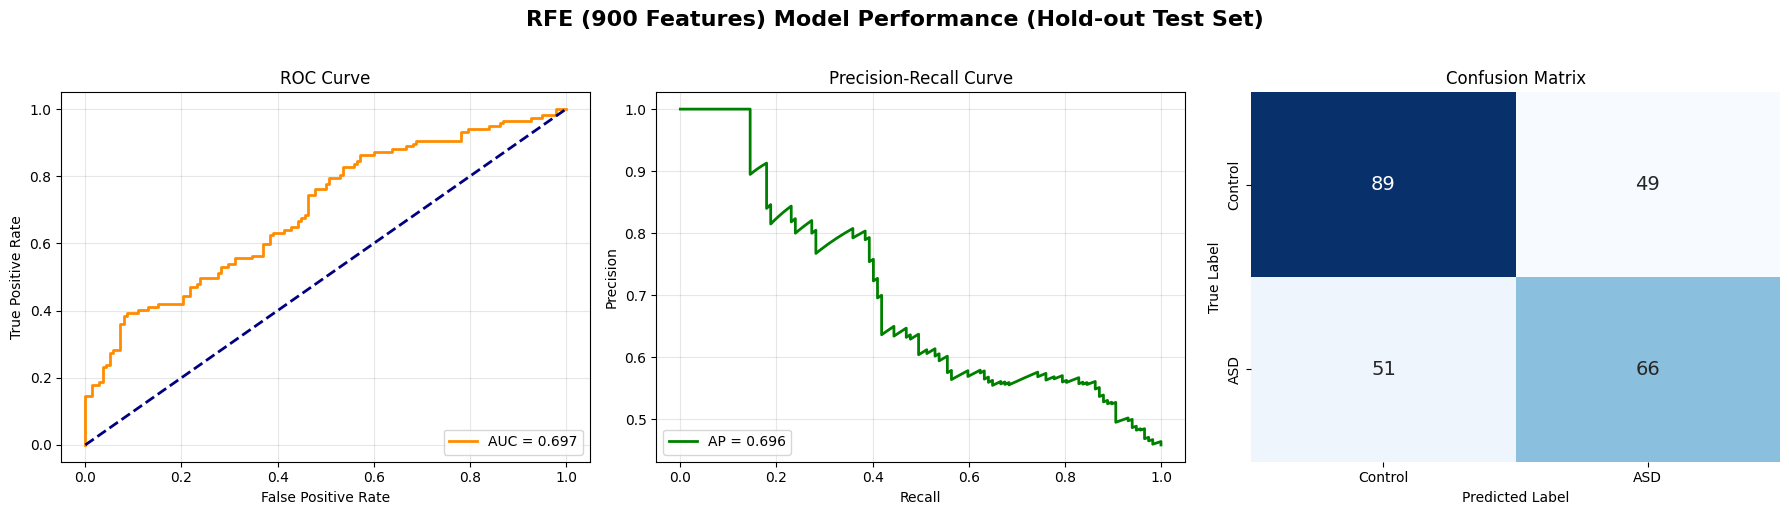


Generating SHAP Feature Importance (Top Features from RFE Selection)...


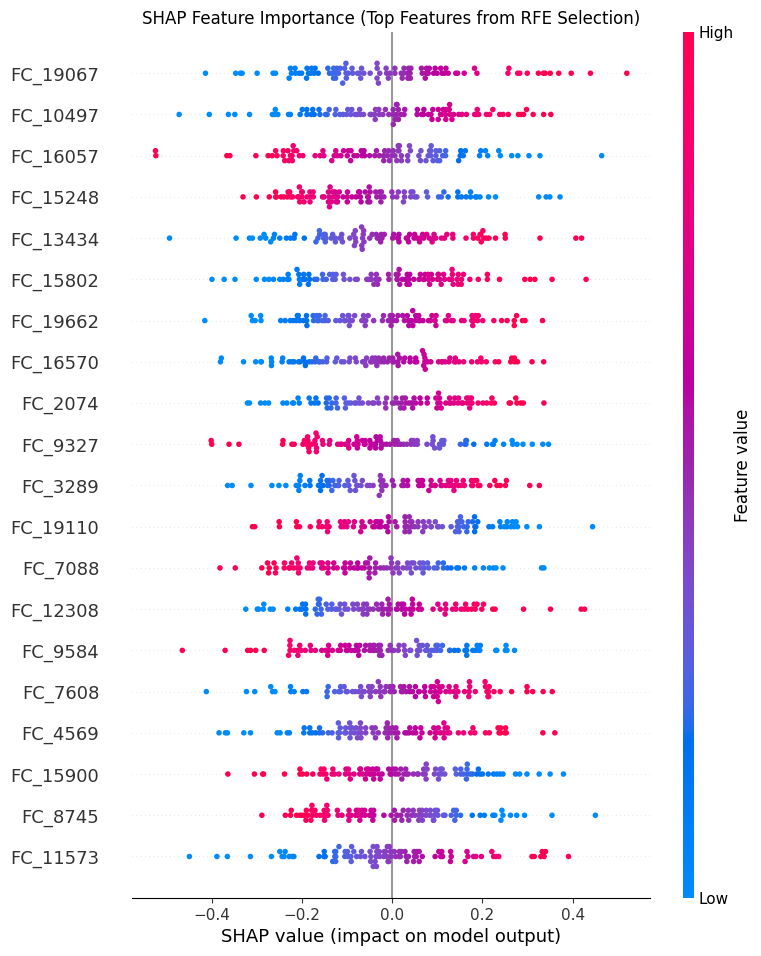

In [ ]:
# ============================================================================
# BLOCK 6: LOGISTIC REGRESSION + RFE (Recursive Feature Elimination)
# ============================================================================
print("\n" + "="*60)
print("BLOCK 6: LOGISTIC REGRESSION + RFE")
print("Target: 900 Features | Speed: Removing 10% per step")
print("="*60)

TARGET_FEATURES = 900

# Enhanced CV function for RFE
def run_rfe_cv(X_data, y_data, k_folds, name, n_features=900):
    print(f"\nStarting {name}... (This will take a moment per fold)")
    cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=SEED)
    metrics = {'acc': [], 'prec': [], 'f1': [], 'auc': []}

    fold = 1
    for train_idx, val_idx in cv.split(X_data, y_data):
        X_tr, X_val = X_data[train_idx], X_data[val_idx]
        y_tr, y_val = y_data[train_idx], y_data[val_idx]

        # Scale
        scaler = StandardScaler()
        X_tr_s = scaler.fit_transform(X_tr)
        X_val_s = scaler.transform(X_val)

        # RFE
        base_model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=SEED)
        rfe = RFE(estimator=base_model, n_features_to_select=n_features, step=0.10)
        X_tr_rfe = rfe.fit_transform(X_tr_s, y_tr)
        X_val_rfe = rfe.transform(X_val_s)

        # Train final model
        model = LogisticRegression(max_iter=1000, random_state=SEED)
        model.fit(X_tr_rfe, y_tr)

        # Evaluate
        y_pred = model.predict(X_val_rfe)
        y_prob = model.predict_proba(X_val_rfe)[:, 1]

        metrics['acc'].append(accuracy_score(y_val, y_pred))
        metrics['prec'].append(precision_score(y_val, y_pred, zero_division=0))
        metrics['f1'].append(f1_score(y_val, y_pred, zero_division=0))
        metrics['auc'].append(roc_auc_score(y_val, y_prob))

        print(f" > Fold {fold} complete.")
        fold += 1

    print(f"\n====== RFE({n_features}) + LR {name} Results ======")
    print(f"Mean Accuracy:  {np.mean(metrics['acc']):.4f} ± {np.std(metrics['acc']):.4f}")
    print(f"Mean Precision: {np.mean(metrics['prec']):.4f} ± {np.std(metrics['prec']):.4f}")
    print(f"Mean F1 Score:  {np.mean(metrics['f1']):.4f} ± {np.std(metrics['f1']):.4f}")
    print(f"Mean AUC:       {np.mean(metrics['auc']):.4f} ± {np.std(metrics['auc']):.4f}")

# Cross-validation
run_rfe_cv(X_dev, y_dev, k_folds=5, name="5-Fold CV", n_features=TARGET_FEATURES)
run_rfe_cv(X_dev, y_dev, k_folds=10, name="10-Fold CV", n_features=TARGET_FEATURES)

# Final model training
print("\nTraining FINAL RFE Model on full Development Set...")

scaler_final = StandardScaler()
X_dev_s = scaler_final.fit_transform(X_dev)
X_test_s = scaler_final.transform(X_test)

base_model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=SEED)
rfe_final = RFE(estimator=base_model, n_features_to_select=TARGET_FEATURES, step=0.10)
X_dev_rfe = rfe_final.fit_transform(X_dev_s, y_dev)
X_test_rfe = rfe_final.transform(X_test_s)

print(f"RFE Selection Complete. Features reduced from {X_dev.shape[1]} to {X_dev_rfe.shape[1]}.")

model_final = LogisticRegression(max_iter=1000, random_state=SEED)
model_final.fit(X_dev_rfe, y_dev)

# Evaluation
y_pred_test, y_prob_test, metrics = evaluate_test_set(model_final, X_test_rfe, y_test)
print_test_results(metrics, f"RFE({TARGET_FEATURES}) FINAL TEST RESULTS")

# Visualization
plot_performance_metrics(y_test, y_pred_test, y_prob_test,
                        f"RFE ({TARGET_FEATURES} Features) Model")

# SHAP Analysis
selected_mask = rfe_final.get_support()
selected_feature_names = feature_names[selected_mask]
plot_shap_analysis(model_final, X_dev_rfe, X_test_rfe, selected_feature_names,
                   "SHAP Feature Importance (Top Features from RFE Selection)")